In [1]:
import argparse
import functools
import os
import pathlib
import sys

os.environ["MUJOCO_GL"] = "osmesa"

import numpy as np
import ruamel.yaml as yaml

import exploration as expl
import models
import tools
import envs.wrappers as wrappers
from parallel import Parallel, Damy

import torch
from torch import nn
from torch import distributions as torchd

import matplotlib.pyplot as plt

from dreamer import Dreamer
import pickle

In [2]:
# with open('logs/20250603_211323/configs_good.pkl', 'rb') as f:
#     config = pickle.load(f)

# from argparse import Namespace

# def print_namespace(ns, indent=0):
#     for key, value in vars(ns).items():
#         if isinstance(value, Namespace):
#             print('  ' * indent + f"{key}:")
#             print_namespace(value, indent + 1)
#         else:
#             print('  ' * indent + f"{key}: {value}")

# # Call the function
# print_namespace(config)

In [3]:
with open('configs.pkl', 'rb') as f:
    config = pickle.load(f)
config.parallel = False
config.time_limit = 5000
print(config.logdir)

logs/20250606_195433


In [4]:
def count_steps(folder):
    return sum(int(str(n).split("-")[-1][:-4]) - 1 for n in folder.glob("*.npz"))

def make_dataset(episodes, config):
    generator = tools.sample_episodes(episodes, config.batch_length)
    dataset = tools.from_generator(generator, config.batch_size)
    return dataset

def make_dataset(episodes, config):
    generator = tools.sample_episodes(episodes, config.batch_length)
    dataset = tools.from_generator(generator, config.batch_size)
    return dataset


def make_env(config):
    suite, task = config.task.split("_", 1)
    import envs.lander3 as lander

    env = lander.LanderEnv(task)
    env = wrappers.NormalizeActions(env)
    env = wrappers.TimeLimit(env, config.time_limit)
    env = wrappers.SelectAction(env, key="action")
    env = wrappers.UUID(env)

    return env


logdir = pathlib.Path(config.logdir).expanduser()

step = count_steps(config.traindir)
logger = tools.Logger(logdir, config.action_repeat * step)

test_env = make_env(config)
test_env = Damy(test_env)
if config.offline_traindir:
    directory = config.offline_traindir.format(**vars(config))
else:
    directory = config.traindir
train_eps = tools.load_episodes(directory, limit=config.dataset_size)
train_dataset = make_dataset(train_eps, config)

acts = test_env.action_space
config.num_actions = acts.n if hasattr(acts, "n") else acts.shape[0]

agent = Dreamer(
        test_env.observation_space,
        test_env.action_space,
        config,
        logger,
        train_dataset,
    ).to(config.device)
agent.requires_grad_(requires_grad=False)

if (logdir / "latest.pt").exists():
    print("Loading latest checkpoint...")
    checkpoint = torch.load(logdir / "latest.pt", weights_only=True)
    agent.load_state_dict(checkpoint["agent_state_dict"])
    tools.recursively_load_optim_state_dict(agent, checkpoint["optims_state_dict"])
    agent._should_pretrain._once = False

Encoder CNN shapes: {}
Encoder MLP shapes: {'state': (4,)}
Decoder CNN shapes: {}
Decoder MLP shapes: {'state': (4,)}
Optimizer model_opt has 12161284 variables.
Optimizer actor_opt has 395782 variables.
Optimizer value_opt has 459775 variables.
Loading latest checkpoint...


# **2 DOF**

Landed!


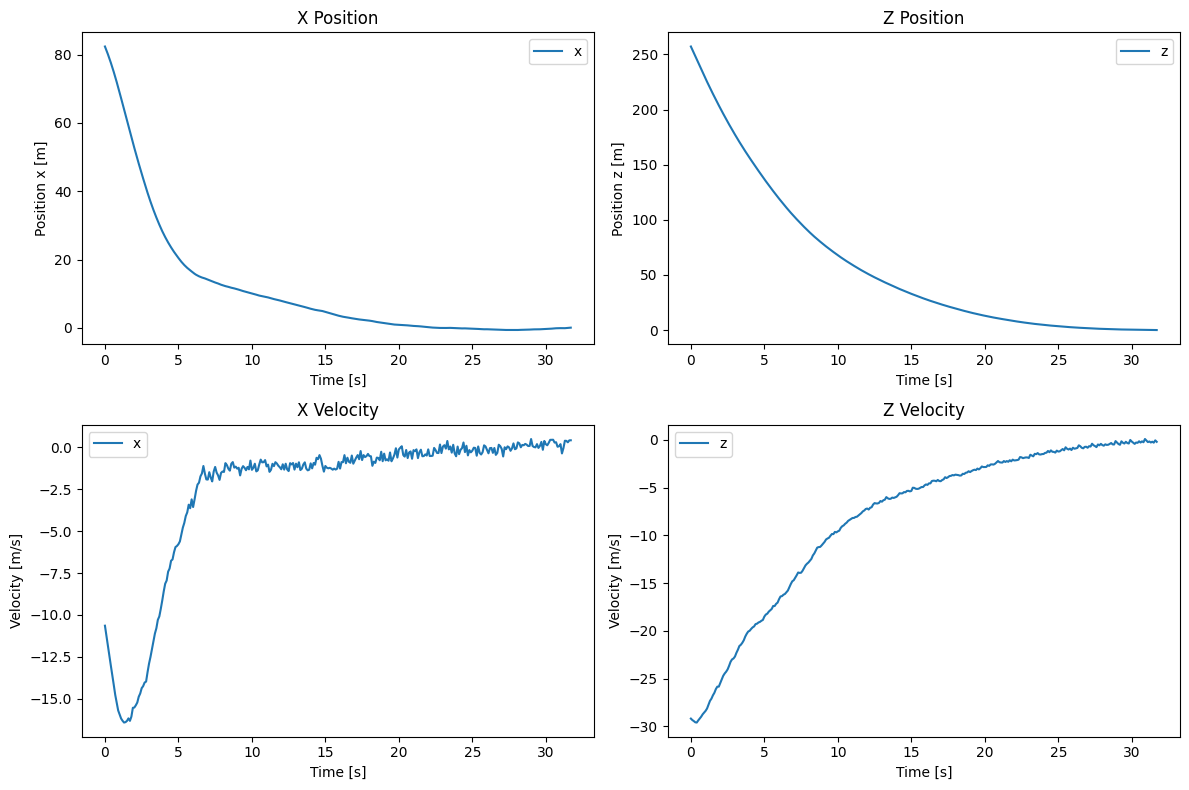

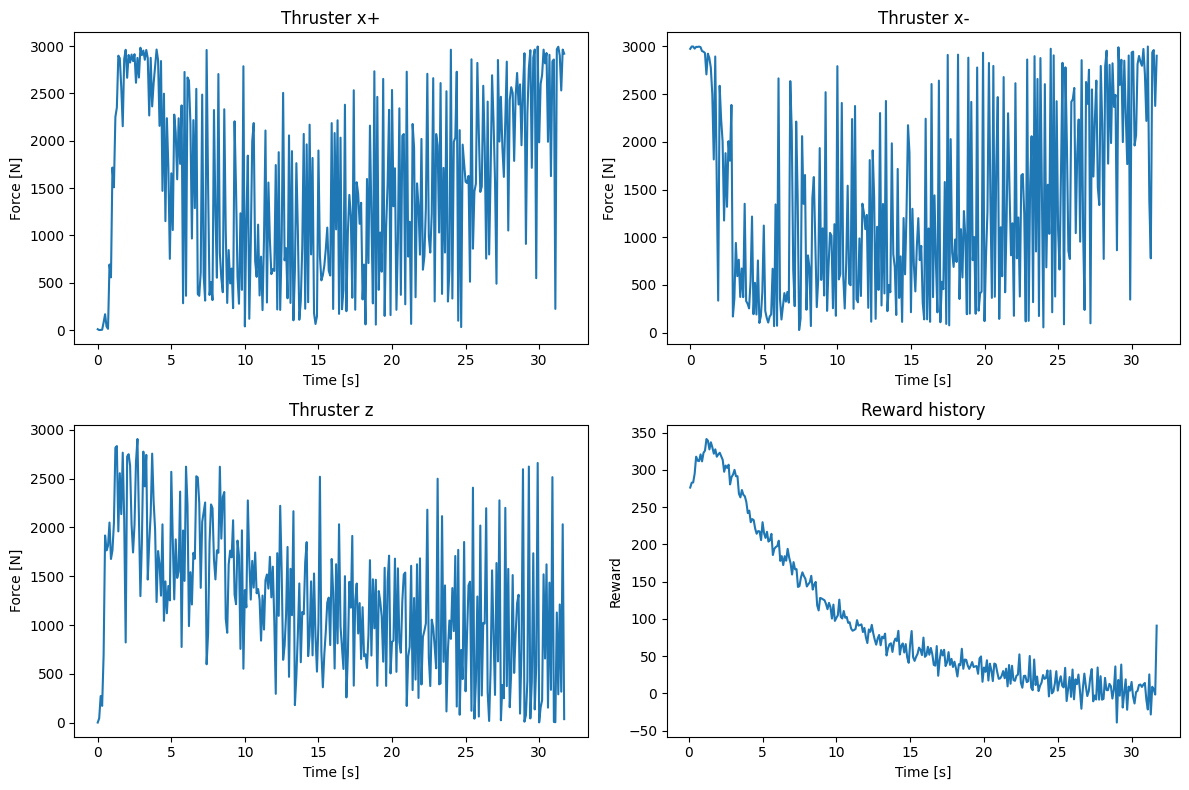

In [12]:
def convert(value, precision=32):
    value = np.array(value)
    if np.issubdtype(value.dtype, np.floating):
        dtype = {16: np.float16, 32: np.float32, 64: np.float64}[precision]
    elif np.issubdtype(value.dtype, np.signedinteger):
        dtype = {16: np.int16, 32: np.int32, 64: np.int64}[precision]
    elif np.issubdtype(value.dtype, np.uint8):
        dtype = np.uint8
    elif np.issubdtype(value.dtype, bool):
        dtype = bool
    else:
        raise NotImplementedError(value.dtype)
    return value.astype(dtype)

def unnormalize(x_norm, min_val, max_val):
    return 0.5 * (x_norm + 1) * (max_val - min_val) + min_val



step, episode = 0, 0
done = np.ones(1, bool)
length = np.zeros(1, np.int32)
obs = [None]
indices = [index for index, d in enumerate(done) if d]      # find indices of done envs
results = [test_env.reset() for i in indices]                # reset done envs
results = [r() for r in results]                            # call the reset functions
for index, result in zip(indices, results): # replacing obs with reset results
    t = result.copy()
    t = {k: convert(v) for k, v in t.items()}
    # action will be added to transition in add_to_cache
    t["reward"] = 0.0
    t["discount"] = 1.0
    obs[index] = result
obs = {k: np.stack([o[k] for o in obs]) for k in obs[0] if "log_" not in k}
agent_state = None
reward = [0]

time = np.arange(0,500,0.1)
state = obs['log/dynstates']
state_hist = []
control_hist = []
reward_hist = []
# action, agent_state = agent(obs, done, agent_state, training=False)



for i, t in enumerate(time):
    action, agent_state = agent(obs, done, agent_state, training=False)
    if isinstance(action, dict):
        action = [
            {k: np.array(action[k][0].detach().cpu()) for k in action}
        ]
    else:
        action = np.array(action)
    
    result = [e.step(a) for e, a in zip([test_env], action)] # step each env with the corresponding action
    result = [r() for r in result]
    obs, reward, done = zip(*[p[:3] for p in result])
    obs = {k: np.stack([o[k] for o in obs]) for k in obs[0] if "log_" not in k}
    done = np.array(done)
    episode += 0
    length += 1
    step += 1
    length *= 1 - 0
    reward_hist.append(reward[0])
    state_hist.append(obs['log/dynstates'][0])
    control_hist.append(unnormalize(action[0]['action'][:3],np.array([0,0,0]), np.array([3000,3000,3000])))
    if obs['is_terminal']: break

time = time[:len(state_hist)]
state_hist = np.array(state_hist)
control_hist = np.array(control_hist)
reward_hist = np.array(reward_hist)


x = state_hist[:, 0]
z = state_hist[:, 1]
x_dot = state_hist[:, 2]
z_dot = state_hist[:, 3]
fig = plt.figure(1, figsize=(12, 8))
ax = fig.add_subplot(2, 2, 1)
ax.plot(time, x)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position x [m]")
ax.set_title("X Position")
ax.legend(["x"])
ax = fig.add_subplot(2, 2, 2)
ax.plot(time,z)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position z [m]")
ax.set_title("Z Position")
ax.legend(["z"])
ax = fig.add_subplot(2, 2, 3)
ax.plot(time,x_dot)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title("X Velocity")
ax.legend(["x"])
ax = fig.add_subplot(2, 2, 4)
ax.plot(time,z_dot)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Velocity [m/s]")
ax.legend(["z"])
ax.set_title("Z Velocity")
plt.tight_layout()
plt.show()

fig2 = plt.figure(2, figsize=(12, 8))
ax2 = fig2.add_subplot(2, 2, 1)
ax2.plot(time, control_hist[:,0])
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Force [N]")
ax2.set_title("Thruster x+")
ax2 = fig2.add_subplot(2, 2, 2)
ax2.plot(time,control_hist[:,1])
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Force [N]")
ax2.set_title("Thruster x-")
ax2 = fig2.add_subplot(2, 2, 3)
ax2.plot(time,control_hist[:,2])
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Force [N]")
ax2.set_title("Thruster z")
ax2 = fig2.add_subplot(2, 2, 4)
ax2.plot(time[1:], reward_hist[1:])
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Reward")
ax2.set_title("Reward history")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3774487/3251459314.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B = np.array([[0, 0, 0], [0, 0, 0], [1/test_env.lander.mass, -1/test_env.lander.mass, 0], [0, 0, 1/test_env.lander.mass]])


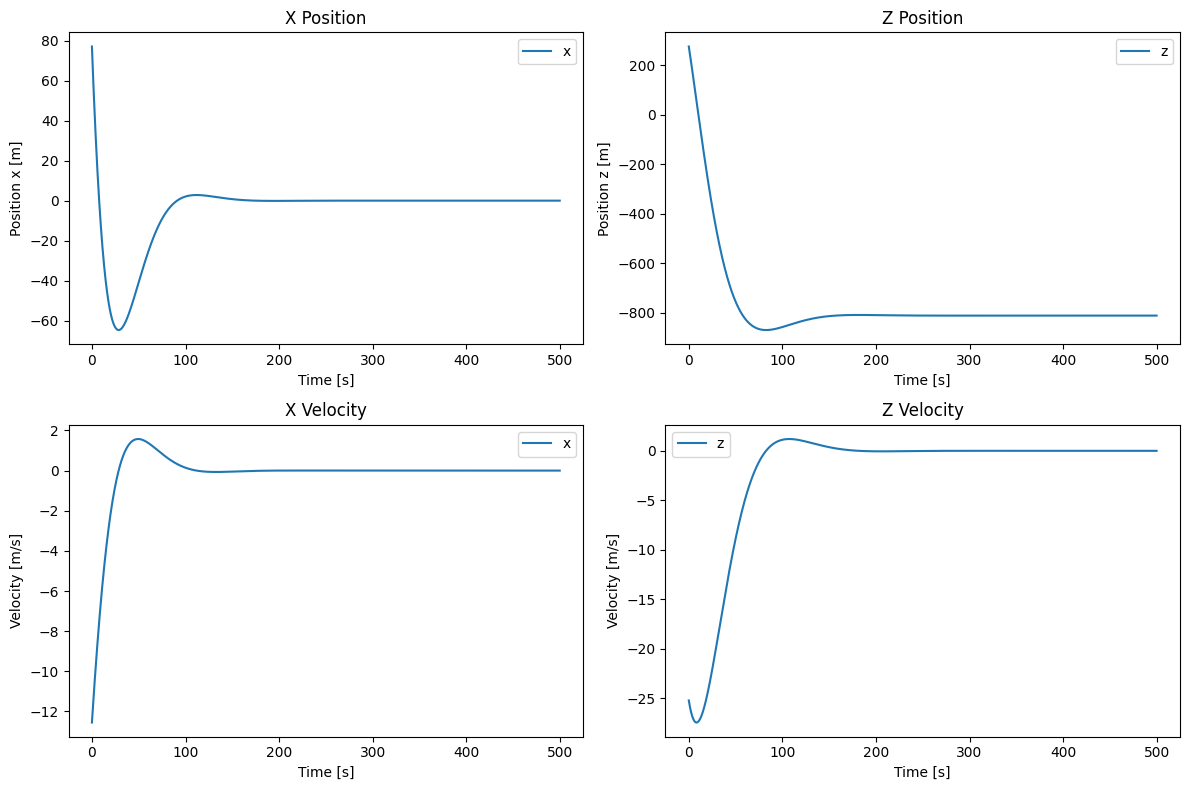

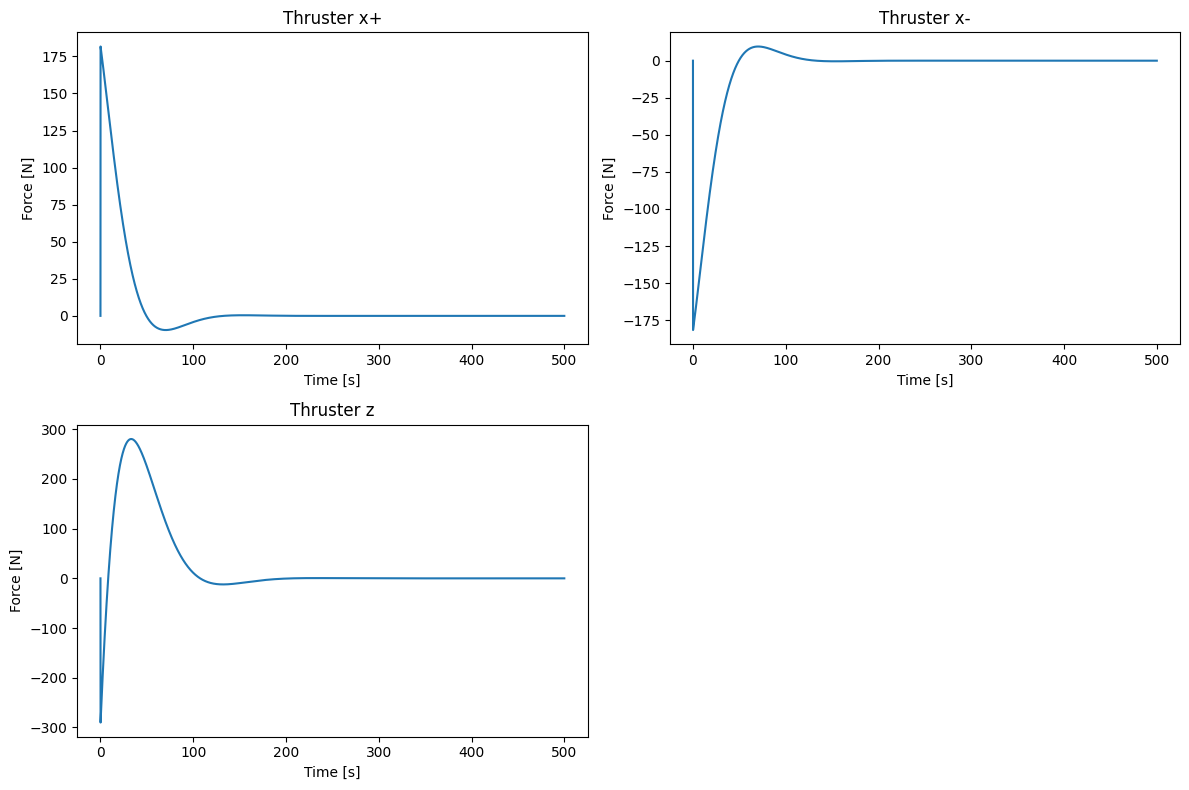

In [6]:
import control as ct
x0 = state_hist[0,:]
state_hist_LQR = np.array([x0])
control_hist_LQR = np.empty((1, 3))

A = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]])
B = np.array([[0, 0, 0], [0, 0, 0], [1/test_env.lander.mass, -1/test_env.lander.mass, 0], [0, 0, 1/test_env.lander.mass]])
g = np.concatenate((np.array([0]), test_env.gravity))

Q = np.diag([1, 1, 1, 1])  # State cost
R = np.diag([1, 1, 1])      # Control cost
K, _, _ = ct.lqr(A, B, Q, R)

time = np.arange(0,500,0.1)

for t in time[1:]:
    u = -K @ x0 + test_env.lander.mass * g  # Control input
    control_hist_LQR = np.append(control_hist_LQR, [u], axis=0)
    x_d = A @ x0 + B @ u  # State update
    x0 = x0 + x_d * 0.1  # Euler integration step
    state_hist_LQR = np.append(state_hist_LQR, [x0], axis=0)




x = state_hist_LQR[:, 0]
z = state_hist_LQR[:, 1]
x_dot = state_hist_LQR[:, 2]
z_dot = state_hist_LQR[:, 3]
fig = plt.figure(1, figsize=(12, 8))
ax = fig.add_subplot(2, 2, 1)
ax.plot(time, x)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position x [m]")
ax.set_title("X Position")
ax.legend(["x"])
ax = fig.add_subplot(2, 2, 2)
ax.plot(time,z)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position z [m]")
ax.set_title("Z Position")
ax.legend(["z"])
ax = fig.add_subplot(2, 2, 3)
ax.plot(time,x_dot)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Velocity [m/s]")
ax.set_title("X Velocity")
ax.legend(["x"])
ax = fig.add_subplot(2, 2, 4)
ax.plot(time,z_dot)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Velocity [m/s]")
ax.legend(["z"])
ax.set_title("Z Velocity")
plt.tight_layout()
plt.show()

fig2 = plt.figure(2, figsize=(12, 8))
ax2 = fig2.add_subplot(2, 2, 1)
ax2.plot(time, control_hist_LQR[:,0])
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Force [N]")
ax2.set_title("Thruster x+")
ax2 = fig2.add_subplot(2, 2, 2)
ax2.plot(time,control_hist_LQR[:,1])
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Force [N]")
ax2.set_title("Thruster x-")
ax2 = fig2.add_subplot(2, 2, 3)
ax2.plot(time,control_hist_LQR[:,2])
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Force [N]")
ax2.set_title("Thruster z")
plt.tight_layout()
plt.show()

In [7]:
from scipy.io import savemat

trajectory = {
    'time': time,
    'state_hist': state_hist}

savemat('output/trajectory.mat', trajectory)

# **6 DOF**

In [8]:
# def convert(value, precision=32):
#     value = np.array(value)
#     if np.issubdtype(value.dtype, np.floating):
#         dtype = {16: np.float16, 32: np.float32, 64: np.float64}[precision]
#     elif np.issubdtype(value.dtype, np.signedinteger):
#         dtype = {16: np.int16, 32: np.int32, 64: np.int64}[precision]
#     elif np.issubdtype(value.dtype, np.uint8):
#         dtype = np.uint8
#     elif np.issubdtype(value.dtype, bool):
#         dtype = bool
#     else:
#         raise NotImplementedError(value.dtype)
#     return value.astype(dtype)

# step, episode = 0, 0
# done = np.ones(1, bool)
# length = np.zeros(1, np.int32)
# obs = [None]
# indices = [index for index, d in enumerate(done) if d]      # find indices of done envs
# results = [test_env.reset() for i in indices]                # reset done envs
# results = [r() for r in results]                            # call the reset functions
# for index, result in zip(indices, results): # replacing obs with reset results
#     t = result.copy()
#     t = {k: convert(v) for k, v in t.items()}
#     # action will be added to transition in add_to_cache
#     t["reward"] = 0.0
#     t["discount"] = 1.0
#     obs[index] = result
# obs = {k: np.stack([o[k] for o in obs]) for k in obs[0] if "log_" not in k}
# agent_state = None
# reward = [0]

# time = np.arange(0,300,0.2)
# state = obs['log/dynstates']
# state_hist = np.zeros((len(time), state.shape[1]))
# control_hist = np.zeros((len(time), 4))

# for i, t in enumerate(time):
#     action, agent_state = agent(obs, done, agent_state, training=False)
#     if isinstance(action, dict):
#         action = [
#             {k: np.array(action[k][0].detach().cpu()) for k in action}
#         ]
#     else:
#         action = np.array(action)
    
#     result = [e.step(a) for e, a in zip([test_env], action)] # step each env with the corresponding action
#     result = [r() for r in result]
#     obs, reward, done = zip(*[p[:3] for p in result])
#     obs = {k: np.stack([o[k] for o in obs]) for k in obs[0] if "log_" not in k}
#     # reward = list(reward)
#     done = np.array(done)
#     episode += 0
#     length += 1
#     step += 1
#     length *= 1 - 0
#     state_hist[i,:] = obs['log/dynstates']
#     control_hist[i,:] = action[0]['action'][:4]

# quat = state_hist[:, 0:4]
# pos = state_hist[:, 4:7]
# vel = state_hist[:, 7:10]
# ang_vel = state_hist[:, 10:13]    
# fig = plt.figure(1, figsize=(12, 8))
# ax = fig.add_subplot(2, 2, 1)
# ax.plot(time, quat)
# ax.set_xlabel("Time")
# ax.set_ylabel("Quaternion")
# ax.set_title("Quaternion")
# ax.legend(["x", "y", "z", "w"])
# ax = fig.add_subplot(2, 2, 2)
# ax.plot(time,pos)
# ax.set_xlabel("Time")
# ax.set_ylabel("Position [m]")
# ax.set_title("Position")
# ax.legend(["x", "y", "z"])
# ax = fig.add_subplot(2, 2, 3)
# ax.plot(time,vel)
# ax.set_xlabel("Time")
# ax.set_ylabel("Velocity [m/s]")
# ax.set_title("Velocity")
# ax.legend(["x", "y", "z"])
# ax = fig.add_subplot(2, 2, 4)
# ax.plot(time,ang_vel)
# ax.set_xlabel("Time")
# ax.set_ylabel("Angular Velocity [rad/s]")
# ax.legend(["x", "y", "z"])
# ax.set_title("Angular Velocity")
# plt.tight_layout()
# plt.show()

# control = action[0]['action']
# fig2 = plt.figure(2, figsize=(12, 8))
# ax2 = fig2.add_subplot(2, 2, 1)
# ax2.plot(time, control_hist[:,0])
# ax2.set_xlabel("Time")
# ax2.set_ylabel("Force [N]")
# ax2.set_title("Thruster 1")
# ax2 = fig2.add_subplot(2, 2, 2)
# ax2.plot(time,control_hist[:,1])
# ax2.set_xlabel("Time")
# ax2.set_ylabel("Force [N]")
# ax2.set_title("Thruster 2")
# ax2 = fig2.add_subplot(2, 2, 3)
# ax2.plot(time,control_hist[:,2])
# ax2.set_xlabel("Time")
# ax2.set_ylabel("Force [N]")
# ax2.set_title("Thruster 3")
# ax2 = fig2.add_subplot(2, 2, 4)
# ax2.plot(time,control_hist[:,3])
# ax2.set_xlabel("Time")
# ax2.set_ylabel("Force [N]")
# ax2.set_title("Thruster 4")
# plt.tight_layout()
# plt.show()